## Create model with PetitRadtrans

In [1]:
from sys import path
path.append('/home/mathisb/Github/')

import os
os.environ['pRT_input_data_path'] = '/home/mathisb/projects/def-ncowan/input_data'

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib  inline

In [5]:
from astropy import constants as const
from astropy import units as u

In [6]:
# import starships.planet_obs as pl_obs
from starships.planet_obs import Planet

# pl_obs=reload(pl_obs)

# import starships.planet_obs as pl_obs
# from starships.planet_obs import Observations,Planet
# 
# pl_obs=reload(pl_obs)

In [7]:
pl_name = 'WASP-33 b'
planet_obj=Planet(pl_name)
planet_obj.ap = 0.0259*u.au
planet_obj.R_star = (planet_obj.ap/3.69).to(u.R_sun)
planet_obj.R_pl = (0.1143*planet_obj.R_star).to(u.R_jup)
planet_obj.M_star = 1.561*const.M_sun


Getting WASP-33 b from ExoFile


/home/mathisb/HighRes/lib/python3.9/site-packages/exofile/archive.py:351: GetLocalFileWarning: DID NOT READ CUSTOM FILE. FileNotFoundError has occur when trying to query/read custom file.
  warn(GetLocalFileWarning(file="custom file", err=e))


In [8]:
import starships.petitradtrans_utils as prt
from petitRADTRANS.physics import guillot_global
from petitRADTRANS import Radtrans

In [9]:
import gc
from starships.spectrum import RotKerTransitCloudy

In [10]:
from astropy.modeling.physical_models import BlackBody as bb

In [11]:
molecules = ['H2O', 'CO']

mol_vmr_log_save = {'H2O': -10.460962699336015,
                    'CO': -4.5809756604704672,
                    'CO2': -9.32730066887895,
                    'FeH': -9.924607502078075,
                    'TiO': -7.2940528637809345,
                    'VO': -7.878547571395368,
                    'C2H2': -7.86252539345477,
                    'HCN': -7.059113617089739,
                    'OH': -4.42793780398837,
                    'H-': -8.672778478857413}
mols_linelists = {'H2O': 'H2O_main_iso',
                  'CO': 'CO_main_iso'}





In [12]:
prt.gen_atm_all??

Signature:
prt.gen_atm_all(
    species_list,
    pressures=None,
    limP=[-12, 4],
    n_pts=150,
    indiv=False,
    **kwargs,
)
Docstring: <no docstring>
Source:   
def gen_atm_all(species_list, pressures=None, limP=[-12, 4], n_pts=150, indiv=False, **kwargs):
    print(species_list)
    if pressures is None:
        pressures = np.logspace(*limP, n_pts)

    if 'He' in species_list:
        species_list.remove('He')
    if 'H2' in species_list:
        species_list.remove('H2')

    atmos_full = gen_atm(species_list, pressures, **kwargs)

    print('Generating atmosphere with pressures from {} to {}'.format(pressures.max(), pressures.min()))
    if indiv is True:
        atmos_i_list = []
        for specie in species_list:
            mol = specie.split('_')[0]
            print('Generating pure {} atmosphere'.format(mol))
            atm_i = gen_atm([specie], pressures, **kwargs)
            atmos_i_list.append(atm_i)

        return atmos_full, pressures, atmos_i_list
    else

In [13]:
atmos_high, pressures = prt.gen_atm_all([mols_linelists[key] for key in molecules],
                                        continuum_opacities=['H-'],
                                        limP=[-10, 2],
                                        n_pts=50, 
                                        mode='lbl',
                                        lbl_opacity_sampling=4,
                                        wl_range=[0.9, 2.55])

['H2O_main_iso', 'CO_main_iso']


/home/mathisb/HighRes/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.
  Read line opacities of CO_main_iso...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Generating atmosphere with pressures from 100.0 to 1e-10
You are not getting the individual contributions of the species


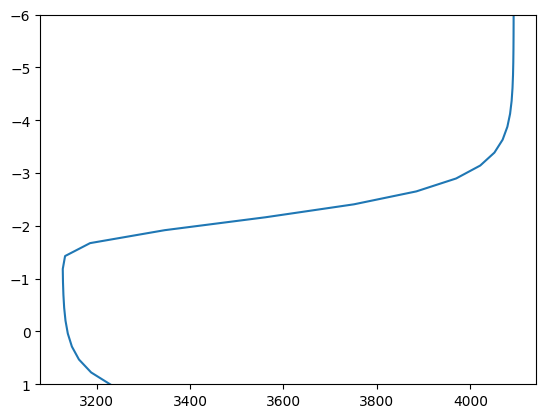

In [14]:
T_int = 500.
T_eq = 3500.
radius = 1.5*const.R_jup


log_gamma = 0.5
log_kappa = -0.5
for log_kappa in [-1]:
    gravity = planet_obj.gp.cgs.value 
    kappa_IR = 10**(log_kappa)
    gamma = 10**log_gamma

    # gravity =planet_obj.gp.cgs.value 

    temp_params = {}
    temp_params['pressures'] = pressures
    temp_params['kappa_IR'] = kappa_IR
    temp_params['gamma'] = gamma
    temp_params['gravity'] = (const.G * planet_obj.M_pl / (radius)**2).cgs.value
    temp_params['T_int'] = T_int
    temp_params['T_eq'] = T_eq
    temp_params['M_pl'] = planet_obj.M_pl

    P0=10 *u.mbar.to(u.bar)
    # log_P0 = np.log10(P0)

    temperatures_day = guillot_global(temp_params['pressures'], 
                             temp_params['kappa_IR'], 
                             temp_params['gamma'], 
                             temp_params['gravity'], 
                             temp_params['T_int'], 
                             temp_params['T_eq'])
    plt.plot(temperatures_day,np.log10(pressures))
    plt.ylim(1,-6)

## CO only

In [21]:
%matplotlib inline

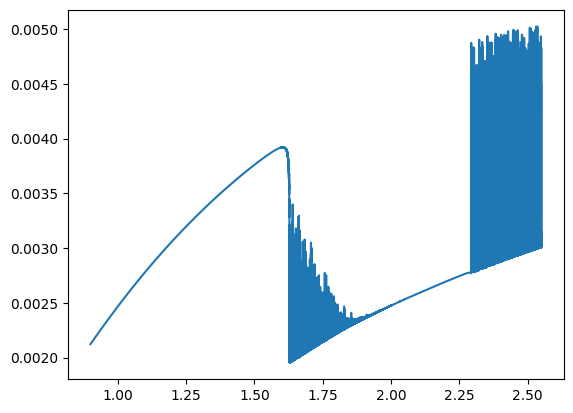

In [22]:
P0=10e-3

cloud = None
mol_vmr_log = {'H2O':-99,
               'CO':-1,
               'H-':-2,
               'e-':-8}

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

species_high["H-"] = 1e-4

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_cont = prt.prepare_model(wlen, flux_lambda, 250000, Raf=64000, rot_params=None)
plt.plot(wave_mod, model_spec_cont)
plt.show()

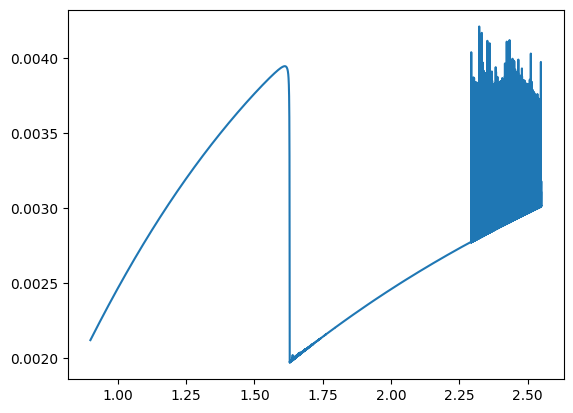

In [23]:
P0=10e-3

cloud = None
mol_vmr_log = {'H2O':-99,
               'CO':-3.5,
               'H-':-2,
               'e-':-8}

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

species_high["H-"] = 1e-4

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_co_day = prt.prepare_model(wlen, flux_lambda, 250000, Raf=64000, rot_params=None)
plt.plot(wave_mod, model_spec_co_day)
plt.show()

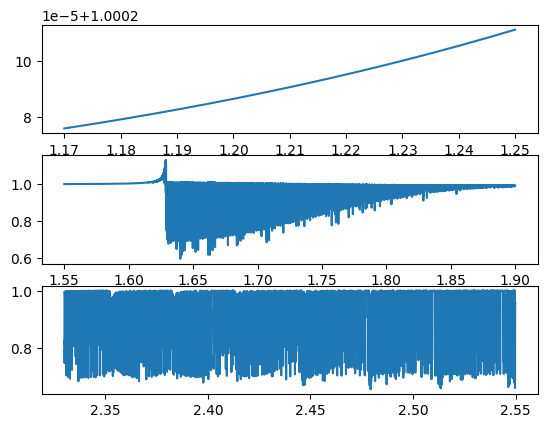

In [24]:
list_wv_range = [(1.17, 1.25), (1.55, 1.9), (2.33, 3.)]


fig, ax = plt.subplots(len(list_wv_range), 1)
try:
    len(ax)
except TypeError:
    ax = [ax]

for ax_i, wv_rng in  zip(ax, list_wv_range):
    cond = (wv_rng[0] < wave_mod) & (wave_mod < wv_rng[-1])
    ax_i.plot(wave_mod[cond], (model_spec_co_day/model_spec_cont)[cond])

plt.show()

In [25]:
np.savez('test_mod_WASP-33_mixed_CO_main_iso', wave_mod=wave_mod, model_spec=model_spec_co_day)

## H2O only